In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00


In [ ]:

from datasets import load_dataset

dataset = load_dataset("rajistics/indian_food_images")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5328 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
})

In [ ]:
labels = [
    "burger", "butter_naan", "chai", "chapati", "chole_bhature",
    "dal_makhani", "dhokla", "fried_rice", "idli", "jalebi",
    "kaathi_rolls", "kadai_paneer", "kulfi", "masala_dosa", "momos",
    "paani_puri", "pakode", "pav_bhaji", "pizza", "samosa"
]

In [ ]:
plt.figure(figsize = (20,20))
for i in range(25):
  plt.subplot(5,5,i+1)
  Im = dataset['train'][i]
  plt.imshow(Im['image'])
  image_label = Im['label']
  plt.xlabel(labels[image_label])
plt.show()

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
id2label[str(4)]

'chole_bhature'

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

size = (image_processor.size["height"], image_processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image


def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [ ]:
dataset["train"].set_transform(preprocess_train)
dataset["test"].set_transform(preprocess_val)

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
# converting our train dataset to tf.data.Dataset

tf_train_dataset = dataset["train"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = dataset["test"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

NameError: name 'batch_size' is not defined

In [ ]:
from transformers import create_optimizer

batch_size = 8
num_epochs = 3
num_train_steps = len(dataset["train"]) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [ ]:
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_eval_dataset)
push_to_hub_callback = PushToHubCallback(
    output_dir="food_classifier_one",
    tokenizer=image_processor,
    save_strategy="no",
)
callbacks = [metric_callback, push_to_hub_callback]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/Vishaltiwari2019/food_classifier_one into local empty directory.


In [ ]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/3
333/333 [==============================] - 610s 2s/step - loss: 2.4354 - val_loss: 1.6935 - accuracy: 0.7566
Epoch 2/3
333/333 [==============================] - 514s 2s/step - loss: 1.6148 - val_loss: 1.1095 - accuracy: 0.8119
Epoch 3/3
333/333 [==============================] - 518s 2s/step - loss: 1.2207 - val_loss: 0.8370 - accuracy: 0.8427


Upload file tf_model.h5:   0%|          | 1.00/328M [00:00<?, ?B/s]

To https://huggingface.co/Vishaltiwari2019/food_classifier_one
   a852ab9..56ee6ca  main -> main

   a852ab9..56ee6ca  main -> main



In [ ]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="Vishaltiwari2019/food_classifier_one")
pipe(image)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at Vishaltiwari2019/food_classifier_one.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


[{'label': 'chai', 'score': 0.660259485244751},
 {'label': 'kulfi', 'score': 0.032649558037519455},
 {'label': 'samosa', 'score': 0.023562809452414513},
 {'label': 'pizza', 'score': 0.022807907313108444},
 {'label': 'masala_dosa', 'score': 0.021070651710033417}]

In [ ]:
result = pipe("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKt7JGApyMVrs_UMGwCJ6LOOgwpYLFrpw-NMt8oKXukWNYVmYrRdHoEiM&s=10")

In [ ]:
res_label = result[0]['label']

In [ ]:
res_label[1:-1

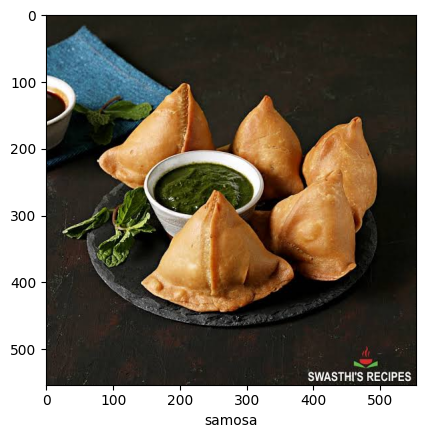

In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# URL of the image you want to download
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKt7JGApyMVrs_UMGwCJ6LOOgwpYLFrpw-NMt8oKXukWNYVmYrRdHoEiM&s=10"

# Send a GET request to the image URL
response = requests.get(image_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Open the image using PIL's Image module
    image = Image.open(BytesIO(response.content))

    # Display the image using matplotlib
    plt.imshow(image)
    plt.xlabel(res_label)
    #plt.axis('off')  # Hide axis
    plt.show()
else:
    print("Failed to download the image.")